In [313]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import qiskit
from qiskit.visualization import array_to_latex

# Primitive MCMC

In [294]:
n = 10
T = 1

In [295]:
def int_to_bin(i, n=None):
    'Convert a given integer to a bitstring of fixed length'
    if n is not None:
        return bin(i)[2:].zfill(n)
    else: return bin(i)[2:]
    
def bin_to_int(s):
    'Convert a given bitstring to integer'
    return int(s,2)

def random_bitstring(n):
    i = np.random.randint(0,2**n)
    return int_to_bin(i, n)

In [296]:
def E(s):
    'Simple energy function'
    if type(s) == type('s'): i = bin_to_int(s)
    else: i = s
    return -np.exp(-(i-16)**2/16)

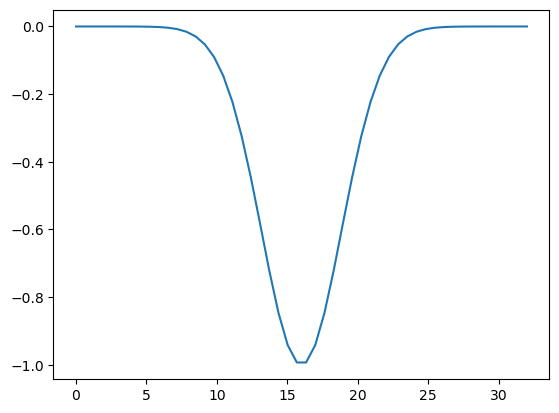

In [297]:
plt.plot(np.linspace(0,32), [E(s) for s in np.linspace(0,32)])

In [298]:
def propose_random():
    '''Propose a random bitstring of length n.'''
    return random_bitstring(n)

def accept(s, s_new,energy_func, T=1):
    '''Determine acceptance based on Metropolis criterion.'''
    A = min(1, np.exp((energy_func(s)-energy_func(s_new)) / T))
    if A >= np.random.uniform(0,1): return True
    else: return False

In [299]:
def samples_to_counts(samples, dtype='str'):
    'Convert sample list to a dictionary of counts'
    counts = {}
    if dtype == 'str':
        for sample in samples:
            if sample in counts: counts[sample] += 1
            else: counts[sample] = 1
    if dtype == 'int':
        for sample in samples:
            if bin_to_int(sample) in counts: counts[bin_to_int(sample)] += 1
            else: counts[bin_to_int(sample)] = 1  
    return counts

In [300]:
samples = []
for i in range(1000):
    s = random_bitstring(n)
    for iter in range(100):
        s_new = propose_random()
        if accept(s, s_new, energy_func = E, T=T): s = s_new
    samples.append(s)

counts = samples_to_counts(samples, dtype='int')

<BarContainer object of 646 artists>

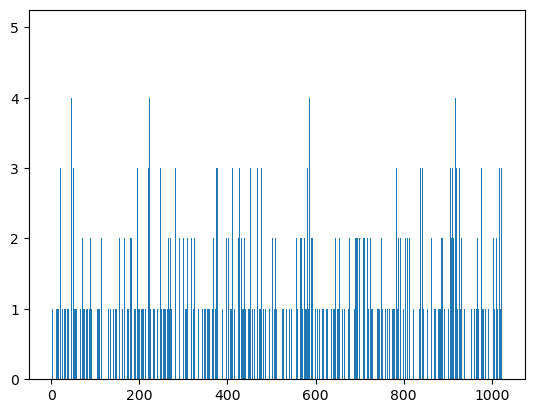

In [301]:
x,y = zip(*counts.items())
plt.bar(x,y)

# Random Ising model

In [302]:
def bin_to_spin(s):
    if len(s) == 1: return 2*int(s)-1
    else:
        l = [2*int(c)-1 for c in s]
        return l

def generate_random_J(n):
    '''Generate a random symmetric coupling matrix for n sites sampled from N(0,1).'''
    J = np.random.standard_normal((n, n))
    J = 0.5 * (J + J.T)  # Ensure symmetry
    np.fill_diagonal(J, 0)  # No self-interactions
    return J

def generate_random_h(n):
    '''Generate random external fields for n sites sampled from N(0,1).'''
    return np.random.standard_normal(n)

def E_ising(s, J, h):
    ''''Calculate the energy of a spin configuration.'''
    energy = 0
    n = len(s)
    if type(s) == type('s'): s = bin_to_spin(s)
    # Interaction term
    for i in range(n):
        for j in range(i + 1, n):
            energy += -J[i, j] * s[i] * s[j]
    # External field term
    for i in range(n):
        energy += -h[i] * s[i]

    return energy

In [303]:
J = generate_random_J(n)
h = generate_random_h(n)

def plot_energy_landscape(energy_func, n):
    x = []
    y = []
    for i in range(2**n):
        s = int_to_bin(i, n) 
        x.append(i)
        y.append(energy_func(s))
    plt.plot(x,y,'o--')

def plot_counts(counts):
    x,y = zip(*counts.items())
    plt.bar(x,y)

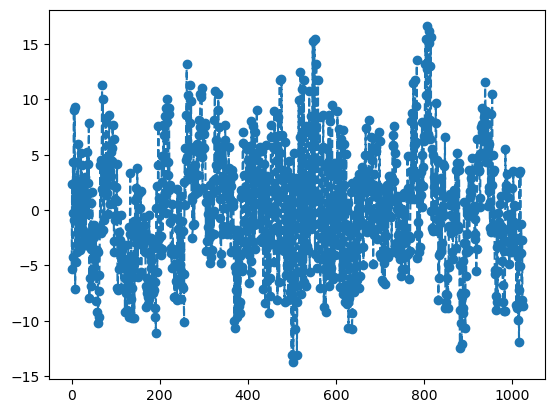

In [304]:
plot_energy_landscape(lambda x: E_ising(x,J,h), n)

In [305]:
samples = []
for i in range(1000):
    s = random_bitstring(n)
    for iter in range(100):
        s_new = propose_random()
        if accept(s, s_new, energy_func = lambda x: E_ising(x, J, h)): s = s_new
    samples.append(s)

counts = samples_to_counts(samples, dtype='int')

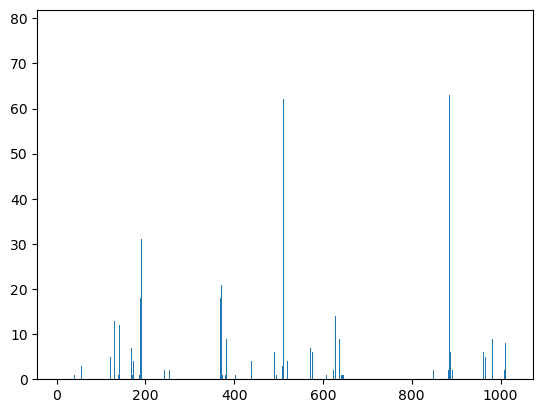

In [306]:
plot_counts(counts)

# Extracting spectral gap

In [307]:
def get_P_matrix_random(n, energy_func, T=1):
    '''Generate a MC transition probability matrix using Metropolis-Hastings algorithm
       with uniform proposal distribution.'''
    P = np.zeros((2**n, 2**n))
    p_propose = 1/2**n # uniform proposal
    for i in range(2**n):
        s_i = int_to_bin(i,n)
        for j in range(2**n):
            s_j = int_to_bin(j,n)
            if i == j: continue # sum for j != i
            A = min(1, np.exp((energy_func(s_i)-energy_func(s_j)) / T)) # MH algorithm
            P[i,j] = A*p_propose
    for i in range(2**n):
        P[i,i] = 1 - sum(P[:,i]) # sum for j == i for normalization
    return P

def get_delta(P):
    '''Calculate the spectral gap of the transition matrix P.'''
    vals, _ = scipy.sparse.linalg.eigs(P)
    sorted_vals = sorted(vals, reverse=True)
    assert np.isclose(sorted_vals[0], 1), f'The largest eigenvalue {sorted_vals[0]} differs from 1!'
    return sorted_vals[0] - sorted_vals[1]
    

In [308]:
def hamming(s1, s2):
    '''Calculate the Hamming distance between two bit strings.'''
    assert len(s1) == len(s2)
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def get_P_matrix_local(n, energy_func, T=1, hamming_radius=1):
    '''Generate a MC transition probability matrix using Metropolis-Hastings algorithm
       with local proposal distribution.'''
    assert hamming_radius <= n
    p_propose = 1 / sum([scipy.special.binom(n,r) for r in range(hamming_radius+1)]) # proposal probability
    P = np.zeros((2**n, 2**n))
    for i in range(2**n):
        s_i = int_to_bin(i,n)
        for j in range(2**n):
            s_j = int_to_bin(j,n)
            if i == j: continue # sum for j != i
            if hamming(s_i, s_j) > hamming_radius: continue # only local spinflips can be proposed
            A = min(1, np.exp((energy_func(s_i)-energy_func(s_j)) / T)) # MH algorithm
            P[i,j] = A * p_propose
    for i in range(2**n):
        P[i,i] = 1 - sum(P[:,i]) # sum for j == i for normalization
    return P

In [309]:
P_random = get_P_matrix_random(n, lambda x: E_ising(x, J, h), T=1)
delta_random = get_delta(P_random)

P_local = get_P_matrix_local(n, lambda x: E_ising(x, J, h), T=1)
delta_local = get_delta(P_local)

In [314]:
T_arr = np.geomspace(0.01, 100, 10)
delta_random_arr = []
delta_local_arr = []
for T in tqdm(T_arr):
    P_random = get_P_matrix_random(n, lambda x: E_ising(x, J, h), T=T)
    delta_random = get_delta(P_random)
    delta_random_arr.append(delta_random)

    P_local = get_P_matrix_local(n, lambda x: E_ising(x, J, h), T=T, hamming_radius=1)
    delta_local = get_delta(P_local)
    delta_local_arr.append(delta_local)

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\ivash\AppData\Local\Temp\ipykernel_1372\433108391.py:11: RuntimeWarning: overflow encountered in exp
  A = min(1, np.exp((energy_func(s_i)-energy_func(s_j)) / T)) # MH algorithm
C:\Users\ivash\AppData\Local\Temp\ipykernel_1372\2918255433.py:18: RuntimeWarning: overflow encountered in exp
  A = min(1, np.exp((energy_func(s_i)-energy_func(s_j)) / T)) # MH algorithm
100%|██████████| 10/10 [12:50<00:00, 77.10s/it]


c:\Users\ivash\anaconda3\envs\qmcmc\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


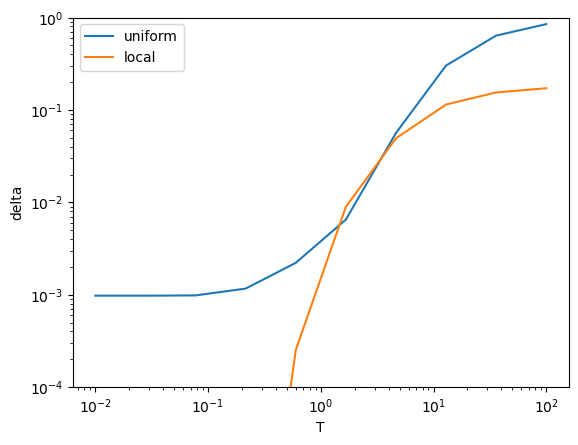

In [316]:
plt.loglog(T_arr, delta_random_arr, label = 'uniform')
plt.loglog(T_arr, delta_local_arr, label = 'local')
plt.xlabel('T')
plt.ylabel('delta')
plt.ylim(0.0001, 1)
plt.legend()